In [1]:
import os
import re
import opensmile
import pandas as pd
import numpy as np
#import model
import matplotlib.pyplot as plt
import seaborn as sb
from opensmile import FeatureSet, FeatureLevel
from contextlib import redirect_stdout

from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters as hp

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
path = 'output/'
output_folder = os.listdir(path)
use_deprecated = False

In [3]:
dict_df_featuresets = {}
pattern = r'(Deprecated)'

for file in output_folder:
    csv_path = path+'/'+file
    temp_df = pd.read_csv(csv_path)
    temp_df = temp_df.drop(axis=1, columns = ['file', 'start', 'end'])
    if use_deprecated:    
        dict_df_featuresets[file[:-4]] = temp_df
    else:
        if re.findall(pattern, csv_path):
            pass
        else:
            dict_df_featuresets[file[:-4]] = temp_df

In [4]:
for featuresets in dict_df_featuresets:
    print(featuresets)
    
history_collection = {}

ComParE_2016
eGeMAPSv01a
eGeMAPSv02
emobase
GeMAPSv01a
GeMAPSv01b


In [5]:
# def sm_model (hp):
def sm_model(num_of_features):
    model = Sequential()
    model.add(Conv1D(256, kernel_size=8, strides = 1, activation='relu', input_shape=(num_of_features,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(128, kernel_size=8, strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(64, kernel_size=8, strides = 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.7))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(9, activation='softmax'))
#     model.add(Dense(7, activation='softmax'))
    
    #opt = hp.Choice("opt", values=['adam', 'sgd', 'rmsprop', 'adadelta', 'adamax', 'adagrad'])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [6]:
features_df = (dict_df_featuresets['emobase'])
print(features_df.shape)

(1975, 989)


In [7]:
X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [8]:
epoch = 100
batch_size = 32

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

#callback_list = [checkpoint, log_csv]
callback_list = [log_csv]

# HP tuner search
# tuner = RandomSearch(hypermodel = sm_model,
#                      objective = "val_acc",
#                      max_trials = 6,
#                      executions_per_trial = 1,
#                      project_name = "Trials")
# tuner.search_space_summary()
# tuner.search(x_train,
#              y_train,
#              epochs = 50,
#              validation_data =(x_val, y_val),
#              verbose = 2
# )
number_of_features = features_df.shape[1] - 1
model_emobase = sm_model(number_of_features)
history_emobase = model_emobase.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_emobase.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

#fig , ax = plt.subplots(1,2)
train_acc = history_emobase.history['acc']
train_loss = history_emobase.history['loss']
test_acc = history_emobase.history['val_acc']
test_loss = history_emobase.history['val_loss']
history_collection['emobase'] = history_emobase

Epoch 1/100
44/44 - 14s - loss: 2.3194 - acc: 0.1635 - val_loss: 2.3040 - val_acc: 0.1831
Epoch 2/100
44/44 - 14s - loss: 1.8628 - acc: 0.2988 - val_loss: 2.9901 - val_acc: 0.1735
Epoch 3/100
44/44 - 14s - loss: 1.6090 - acc: 0.3900 - val_loss: 4.3941 - val_acc: 0.1735
Epoch 4/100
44/44 - 14s - loss: 1.4694 - acc: 0.4711 - val_loss: 5.9788 - val_acc: 0.1735
Epoch 5/100
44/44 - 14s - loss: 1.2872 - acc: 0.5159 - val_loss: 6.5520 - val_acc: 0.1759
Epoch 6/100
44/44 - 14s - loss: 1.1506 - acc: 0.5695 - val_loss: 5.6838 - val_acc: 0.1783
Epoch 7/100
44/44 - 14s - loss: 1.0470 - acc: 0.5991 - val_loss: 4.2922 - val_acc: 0.2313
Epoch 8/100
44/44 - 14s - loss: 0.9130 - acc: 0.6802 - val_loss: 3.8506 - val_acc: 0.2675
Epoch 9/100
44/44 - 14s - loss: 0.8299 - acc: 0.6968 - val_loss: 2.9058 - val_acc: 0.3807
Epoch 10/100
44/44 - 15s - loss: 0.7574 - acc: 0.7265 - val_loss: 2.7412 - val_acc: 0.3904
Epoch 11/100
44/44 - 14s - loss: 0.7114 - acc: 0.7373 - val_loss: 2.3175 - val_acc: 0.4193
Epoch 12

44/44 - 18s - loss: 0.0343 - acc: 0.9884 - val_loss: 2.1115 - val_acc: 0.6602
Epoch 92/100
44/44 - 17s - loss: 0.0451 - acc: 0.9819 - val_loss: 1.9762 - val_acc: 0.6506
Epoch 93/100
44/44 - 17s - loss: 0.0369 - acc: 0.9891 - val_loss: 2.2477 - val_acc: 0.6506
Epoch 94/100
44/44 - 21s - loss: 0.0679 - acc: 0.9834 - val_loss: 2.2655 - val_acc: 0.6482
Epoch 95/100
44/44 - 22s - loss: 0.0496 - acc: 0.9783 - val_loss: 2.2580 - val_acc: 0.6554
Epoch 96/100
44/44 - 18s - loss: 0.0458 - acc: 0.9819 - val_loss: 2.2378 - val_acc: 0.6506
Epoch 97/100
44/44 - 20s - loss: 0.0822 - acc: 0.9725 - val_loss: 1.9696 - val_acc: 0.6602
Epoch 98/100
44/44 - 20s - loss: 0.0731 - acc: 0.9790 - val_loss: 2.0657 - val_acc: 0.6602
Epoch 99/100
44/44 - 19s - loss: 0.0749 - acc: 0.9797 - val_loss: 2.0075 - val_acc: 0.6530
Epoch 100/100
44/44 - 19s - loss: 0.0569 - acc: 0.9783 - val_loss: 2.2178 - val_acc: 0.6602
6/6 - 0s - loss: 2.0174 - acc: 0.6404
Accuracy of our model on test data :  64.04494643211365 %


In [9]:
features_df = (dict_df_featuresets['ComParE_2016'])
X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [10]:
epoch = 100
batch_size = 32

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

#callback_list = [checkpoint, log_csv]
callback_list = [log_csv]

# HP tuner search
# tuner = RandomSearch(hypermodel = sm_model,
#                      objective = "val_acc",
#                      max_trials = 6,
#                      executions_per_trial = 1,
#                      project_name = "Trials")
# tuner.search_space_summary()
# tuner.search(x_train,
#              y_train,
#              epochs = 50,
#              validation_data =(x_val, y_val),
#              verbose = 2
# )
number_of_features = features_df.shape[1] - 1
model_ComParE_2016 = sm_model(number_of_features)
history_ComParE_2016 = model_ComParE_2016.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_ComParE_2016.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

#fig , ax = plt.subplots(1,2)
train_acc = history_ComParE_2016.history['acc']
train_loss = history_ComParE_2016.history['loss']
test_acc = history_ComParE_2016.history['val_acc']
test_loss = history_ComParE_2016.history['val_loss']
history_collection['ComParE_2016'] = history_ComParE_2016

Epoch 1/100
44/44 - 117s - loss: 2.2122 - acc: 0.2446 - val_loss: 9.2795 - val_acc: 0.1590
Epoch 2/100
44/44 - 117s - loss: 1.6813 - acc: 0.3640 - val_loss: 4.4900 - val_acc: 0.1422
Epoch 3/100
44/44 - 115s - loss: 1.4349 - acc: 0.4732 - val_loss: 6.0950 - val_acc: 0.1470
Epoch 4/100
44/44 - 115s - loss: 1.2230 - acc: 0.5586 - val_loss: 4.6721 - val_acc: 0.1301
Epoch 5/100
44/44 - 116s - loss: 0.9695 - acc: 0.6375 - val_loss: 4.1159 - val_acc: 0.1518
Epoch 6/100
44/44 - 115s - loss: 0.8128 - acc: 0.6896 - val_loss: 3.5073 - val_acc: 0.2313
Epoch 7/100
44/44 - 115s - loss: 0.6792 - acc: 0.7619 - val_loss: 4.6617 - val_acc: 0.2120
Epoch 8/100
44/44 - 116s - loss: 0.5221 - acc: 0.8213 - val_loss: 4.9168 - val_acc: 0.2337
Epoch 9/100
44/44 - 116s - loss: 0.4674 - acc: 0.8423 - val_loss: 3.1687 - val_acc: 0.3253
Epoch 10/100
44/44 - 102s - loss: 0.3548 - acc: 0.8864 - val_loss: 2.1298 - val_acc: 0.4627
Epoch 11/100
44/44 - 94s - loss: 0.2875 - acc: 0.8951 - val_loss: 1.9931 - val_acc: 0.537

Epoch 91/100
44/44 - 95s - loss: 0.0673 - acc: 0.9826 - val_loss: 3.3461 - val_acc: 0.6361
Epoch 92/100
44/44 - 95s - loss: 0.0326 - acc: 0.9877 - val_loss: 3.3935 - val_acc: 0.6530
Epoch 93/100
44/44 - 94s - loss: 0.0200 - acc: 0.9942 - val_loss: 3.2421 - val_acc: 0.6554
Epoch 94/100
44/44 - 95s - loss: 0.0492 - acc: 0.9841 - val_loss: 3.6417 - val_acc: 0.6386
Epoch 95/100
44/44 - 94s - loss: 0.0515 - acc: 0.9884 - val_loss: 3.3428 - val_acc: 0.6265
Epoch 96/100
44/44 - 94s - loss: 0.0479 - acc: 0.9870 - val_loss: 3.6970 - val_acc: 0.6337
Epoch 97/100
44/44 - 95s - loss: 0.0470 - acc: 0.9891 - val_loss: 3.3553 - val_acc: 0.6072
Epoch 98/100
44/44 - 95s - loss: 0.0273 - acc: 0.9935 - val_loss: 3.4355 - val_acc: 0.6337
Epoch 99/100
44/44 - 95s - loss: 0.0477 - acc: 0.9891 - val_loss: 3.1635 - val_acc: 0.6602
Epoch 100/100
44/44 - 95s - loss: 0.0691 - acc: 0.9834 - val_loss: 3.9137 - val_acc: 0.6410
6/6 - 2s - loss: 4.2451 - acc: 0.6067
Accuracy of our model on test data :  60.6741547584

NameError: name 'history_compare2016' is not defined

In [14]:
history_collection['ComParE_2016'] = history_ComParE_2016

In [15]:
features_df = (dict_df_featuresets['eGeMAPSv01a'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [16]:
epoch = 100
batch_size = 32

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

#callback_list = [checkpoint, log_csv]
callback_list = [log_csv]

# HP tuner search
# tuner = RandomSearch(hypermodel = sm_model,
#                      objective = "val_acc",
#                      max_trials = 6,
#                      executions_per_trial = 1,
#                      project_name = "Trials")
# tuner.search_space_summary()
# tuner.search(x_train,
#              y_train,
#              epochs = 50,
#              validation_data =(x_val, y_val),
#              verbose = 2
# )
number_of_features = features_df.shape[1] - 1
model_eGeMAPSv01a = sm_model(number_of_features)
history_eGeMAPSv01a = model_eGeMAPSv01a.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_eGeMAPSv01a.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

#fig , ax = plt.subplots(1,2)
train_acc = history_eGeMAPSv01a.history['acc']
train_loss = history_eGeMAPSv01a.history['loss']
test_acc = history_eGeMAPSv01a.history['val_acc']
test_loss = history_eGeMAPSv01a.history['val_loss']
history_collection['eGeMAPSv01a'] = history_eGeMAPSv01a

Epoch 1/100
44/44 - 2s - loss: 2.5036 - acc: 0.1664 - val_loss: 2.1387 - val_acc: 0.1952
Epoch 2/100
44/44 - 1s - loss: 2.0889 - acc: 0.2482 - val_loss: 2.1596 - val_acc: 0.1711
Epoch 3/100
44/44 - 1s - loss: 1.9281 - acc: 0.2822 - val_loss: 2.2025 - val_acc: 0.1687
Epoch 4/100
44/44 - 1s - loss: 1.8992 - acc: 0.2945 - val_loss: 2.2884 - val_acc: 0.1711
Epoch 5/100
44/44 - 1s - loss: 1.7988 - acc: 0.3205 - val_loss: 2.2647 - val_acc: 0.1735
Epoch 6/100
44/44 - 1s - loss: 1.7603 - acc: 0.3350 - val_loss: 2.3206 - val_acc: 0.1904
Epoch 7/100
44/44 - 1s - loss: 1.7083 - acc: 0.3582 - val_loss: 2.1302 - val_acc: 0.2578
Epoch 8/100
44/44 - 1s - loss: 1.7050 - acc: 0.3589 - val_loss: 1.9621 - val_acc: 0.2651
Epoch 9/100
44/44 - 1s - loss: 1.6364 - acc: 0.3748 - val_loss: 1.8224 - val_acc: 0.3446
Epoch 10/100
44/44 - 1s - loss: 1.5964 - acc: 0.3777 - val_loss: 1.7279 - val_acc: 0.3542
Epoch 11/100
44/44 - 1s - loss: 1.5793 - acc: 0.3987 - val_loss: 1.5974 - val_acc: 0.3928
Epoch 12/100
44/44 

44/44 - 1s - loss: 0.7519 - acc: 0.7243 - val_loss: 1.1743 - val_acc: 0.5663
Epoch 93/100
44/44 - 1s - loss: 0.7421 - acc: 0.7315 - val_loss: 1.1607 - val_acc: 0.6048
Epoch 94/100
44/44 - 1s - loss: 0.7461 - acc: 0.7294 - val_loss: 1.1870 - val_acc: 0.5807
Epoch 95/100
44/44 - 1s - loss: 0.7380 - acc: 0.7142 - val_loss: 1.1809 - val_acc: 0.5687
Epoch 96/100
44/44 - 1s - loss: 0.6966 - acc: 0.7533 - val_loss: 1.1649 - val_acc: 0.5735
Epoch 97/100
44/44 - 1s - loss: 0.7500 - acc: 0.7294 - val_loss: 1.1616 - val_acc: 0.5735
Epoch 98/100
44/44 - 1s - loss: 0.7184 - acc: 0.7359 - val_loss: 1.1789 - val_acc: 0.5687
Epoch 99/100
44/44 - 1s - loss: 0.7116 - acc: 0.7446 - val_loss: 1.1886 - val_acc: 0.5735
Epoch 100/100
44/44 - 1s - loss: 0.7350 - acc: 0.7366 - val_loss: 1.2485 - val_acc: 0.5783
6/6 - 0s - loss: 1.2264 - acc: 0.5506
Accuracy of our model on test data :  55.0561785697937 %


In [17]:
features_df = (dict_df_featuresets['eGeMAPSv02'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [18]:
epoch = 100
batch_size = 32

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

#callback_list = [checkpoint, log_csv]
callback_list = [log_csv]

# HP tuner search
# tuner = RandomSearch(hypermodel = sm_model,
#                      objective = "val_acc",
#                      max_trials = 6,
#                      executions_per_trial = 1,
#                      project_name = "Trials")
# tuner.search_space_summary()
# tuner.search(x_train,
#              y_train,
#              epochs = 50,
#              validation_data =(x_val, y_val),
#              verbose = 2
# )
number_of_features = features_df.shape[1] - 1
model_eGeMAPSv02 = sm_model(number_of_features)
history_eGeMAPSv02 = model_eGeMAPSv02.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_eGeMAPSv02.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

#fig , ax = plt.subplots(1,2)
train_acc = history_eGeMAPSv02.history['acc']
train_loss = history_eGeMAPSv02.history['loss']
test_acc = history_eGeMAPSv02.history['val_acc']
test_loss = history_eGeMAPSv02.history['val_loss']
history_collection['eGeMAPSv02'] = history_eGeMAPSv02

Epoch 1/100
44/44 - 2s - loss: 2.5319 - acc: 0.1758 - val_loss: 2.1951 - val_acc: 0.1181
Epoch 2/100
44/44 - 1s - loss: 2.1129 - acc: 0.2323 - val_loss: 2.2381 - val_acc: 0.1108
Epoch 3/100
44/44 - 1s - loss: 1.9889 - acc: 0.2460 - val_loss: 2.2661 - val_acc: 0.1060
Epoch 4/100
44/44 - 1s - loss: 1.9036 - acc: 0.3061 - val_loss: 2.3576 - val_acc: 0.1205
Epoch 5/100
44/44 - 1s - loss: 1.8172 - acc: 0.3408 - val_loss: 2.3715 - val_acc: 0.1373
Epoch 6/100
44/44 - 1s - loss: 1.7570 - acc: 0.3690 - val_loss: 2.3220 - val_acc: 0.2000
Epoch 7/100
44/44 - 1s - loss: 1.7151 - acc: 0.3603 - val_loss: 2.1773 - val_acc: 0.2940
Epoch 8/100
44/44 - 1s - loss: 1.6538 - acc: 0.3828 - val_loss: 2.0957 - val_acc: 0.2940
Epoch 9/100
44/44 - 1s - loss: 1.5920 - acc: 0.3987 - val_loss: 1.9774 - val_acc: 0.3060
Epoch 10/100
44/44 - 1s - loss: 1.5836 - acc: 0.4240 - val_loss: 1.7438 - val_acc: 0.3759
Epoch 11/100
44/44 - 1s - loss: 1.5602 - acc: 0.4081 - val_loss: 1.6441 - val_acc: 0.4000
Epoch 12/100
44/44 

44/44 - 1s - loss: 0.7128 - acc: 0.7344 - val_loss: 1.1907 - val_acc: 0.5928
Epoch 93/100
44/44 - 1s - loss: 0.6912 - acc: 0.7482 - val_loss: 1.1724 - val_acc: 0.5928
Epoch 94/100
44/44 - 1s - loss: 0.7423 - acc: 0.7221 - val_loss: 1.1665 - val_acc: 0.5831
Epoch 95/100
44/44 - 1s - loss: 0.7024 - acc: 0.7417 - val_loss: 1.2132 - val_acc: 0.5783
Epoch 96/100
44/44 - 1s - loss: 0.7543 - acc: 0.7214 - val_loss: 1.1828 - val_acc: 0.6048
Epoch 97/100
44/44 - 1s - loss: 0.7154 - acc: 0.7424 - val_loss: 1.1952 - val_acc: 0.6048
Epoch 98/100
44/44 - 1s - loss: 0.7032 - acc: 0.7337 - val_loss: 1.2039 - val_acc: 0.5880
Epoch 99/100
44/44 - 1s - loss: 0.6643 - acc: 0.7388 - val_loss: 1.1535 - val_acc: 0.6217
Epoch 100/100
44/44 - 1s - loss: 0.6475 - acc: 0.7670 - val_loss: 1.1601 - val_acc: 0.6000
6/6 - 0s - loss: 1.1149 - acc: 0.5787
Accuracy of our model on test data :  57.865166664123535 %


In [19]:
features_df = (dict_df_featuresets['GeMAPSv01a'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [20]:
epoch = 100
batch_size = 32

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

#callback_list = [checkpoint, log_csv]
callback_list = [log_csv]

# HP tuner search
# tuner = RandomSearch(hypermodel = sm_model,
#                      objective = "val_acc",
#                      max_trials = 6,
#                      executions_per_trial = 1,
#                      project_name = "Trials")
# tuner.search_space_summary()
# tuner.search(x_train,
#              y_train,
#              epochs = 50,
#              validation_data =(x_val, y_val),
#              verbose = 2
# )
number_of_features = features_df.shape[1] - 1
model_GeMAPSv01a = sm_model(number_of_features)
history_GeMAPSv01a = model_GeMAPSv01a.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_GeMAPSv01a.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

#fig , ax = plt.subplots(1,2)
train_acc = history_GeMAPSv01a.history['acc']
train_loss = history_GeMAPSv01a.history['loss']
test_acc = history_GeMAPSv01a.history['val_acc']
test_loss = history_GeMAPSv01a.history['val_loss']
history_collection['GeMAPSv01a'] = history_GeMAPSv01a

Epoch 1/100
44/44 - 1s - loss: 2.3683 - acc: 0.1766 - val_loss: 2.1558 - val_acc: 0.2072
Epoch 2/100
44/44 - 1s - loss: 2.0686 - acc: 0.2279 - val_loss: 2.1311 - val_acc: 0.1373
Epoch 3/100
44/44 - 1s - loss: 1.9366 - acc: 0.2417 - val_loss: 2.1254 - val_acc: 0.1325
Epoch 4/100
44/44 - 1s - loss: 1.9161 - acc: 0.2735 - val_loss: 2.1403 - val_acc: 0.1277
Epoch 5/100
44/44 - 1s - loss: 1.8603 - acc: 0.2909 - val_loss: 2.2081 - val_acc: 0.1301
Epoch 6/100
44/44 - 1s - loss: 1.7762 - acc: 0.3133 - val_loss: 2.1491 - val_acc: 0.2072
Epoch 7/100
44/44 - 1s - loss: 1.7794 - acc: 0.3350 - val_loss: 2.0720 - val_acc: 0.2747
Epoch 8/100
44/44 - 1s - loss: 1.7221 - acc: 0.3350 - val_loss: 1.9504 - val_acc: 0.2795
Epoch 9/100
44/44 - 1s - loss: 1.6575 - acc: 0.3777 - val_loss: 1.8243 - val_acc: 0.3422
Epoch 10/100
44/44 - 1s - loss: 1.6504 - acc: 0.3690 - val_loss: 1.7472 - val_acc: 0.3277
Epoch 11/100
44/44 - 1s - loss: 1.6440 - acc: 0.3734 - val_loss: 1.6379 - val_acc: 0.3711
Epoch 12/100
44/44 

44/44 - 1s - loss: 0.9141 - acc: 0.6722 - val_loss: 1.1081 - val_acc: 0.5952
Epoch 93/100
44/44 - 1s - loss: 0.9446 - acc: 0.6585 - val_loss: 1.1091 - val_acc: 0.5928
Epoch 94/100
44/44 - 1s - loss: 0.9088 - acc: 0.6664 - val_loss: 1.0855 - val_acc: 0.6048
Epoch 95/100
44/44 - 1s - loss: 0.8573 - acc: 0.6744 - val_loss: 1.0986 - val_acc: 0.6000
Epoch 96/100
44/44 - 1s - loss: 0.9347 - acc: 0.6614 - val_loss: 1.1056 - val_acc: 0.5952
Epoch 97/100
44/44 - 1s - loss: 0.9240 - acc: 0.6650 - val_loss: 1.0867 - val_acc: 0.5928
Epoch 98/100
44/44 - 1s - loss: 0.8699 - acc: 0.6751 - val_loss: 1.0936 - val_acc: 0.6024
Epoch 99/100
44/44 - 1s - loss: 0.9097 - acc: 0.6693 - val_loss: 1.0991 - val_acc: 0.5952
Epoch 100/100
44/44 - 1s - loss: 0.8650 - acc: 0.6795 - val_loss: 1.0945 - val_acc: 0.6169
6/6 - 0s - loss: 1.1289 - acc: 0.5618
Accuracy of our model on test data :  56.179773807525635 %


In [21]:
features_df = (dict_df_featuresets['GeMAPSv01b'])

X = features_df.drop('label', axis=1)
Y = features_df['label']

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3 , shuffle=True, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [22]:
epoch = 100
batch_size = 32

filepath = 'saved_models/weght-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_acc', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='max')

# Log epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('logs_testrun1.csv',
                    separator=',', 
                    append=True)

#callback_list = [checkpoint, log_csv]
callback_list = [log_csv]

# HP tuner search
# tuner = RandomSearch(hypermodel = sm_model,
#                      objective = "val_acc",
#                      max_trials = 6,
#                      executions_per_trial = 1,
#                      project_name = "Trials")
# tuner.search_space_summary()
# tuner.search(x_train,
#              y_train,
#              epochs = 50,
#              validation_data =(x_val, y_val),
#              verbose = 2
# )
number_of_features = features_df.shape[1] - 1
model_GeMAPSv01b = sm_model(number_of_features)
history_GeMAPSv01b = model_GeMAPSv01b.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=2,
                    callbacks = callback_list)

print("Accuracy of our model on test data : " , model_GeMAPSv01b.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

#fig , ax = plt.subplots(1,2)
train_acc = history_GeMAPSv01b.history['acc']
train_loss = history_GeMAPSv01b.history['loss']
test_acc = history_GeMAPSv01b.history['val_acc']
test_loss = history_GeMAPSv01b.history['val_loss']
history_collection['GeMAPSv01a'] = history_GeMAPSv01b

Epoch 1/100
44/44 - 1s - loss: 2.4610 - acc: 0.1744 - val_loss: 2.1571 - val_acc: 0.1759
Epoch 2/100
44/44 - 1s - loss: 2.0706 - acc: 0.2287 - val_loss: 2.1336 - val_acc: 0.1301
Epoch 3/100
44/44 - 1s - loss: 1.9936 - acc: 0.2540 - val_loss: 2.1173 - val_acc: 0.2000
Epoch 4/100
44/44 - 1s - loss: 1.8854 - acc: 0.2902 - val_loss: 2.0989 - val_acc: 0.2145
Epoch 5/100
44/44 - 1s - loss: 1.8039 - acc: 0.3090 - val_loss: 2.0708 - val_acc: 0.2434
Epoch 6/100
44/44 - 1s - loss: 1.7416 - acc: 0.3198 - val_loss: 1.9989 - val_acc: 0.2313
Epoch 7/100
44/44 - 1s - loss: 1.7569 - acc: 0.3379 - val_loss: 1.9429 - val_acc: 0.2554
Epoch 8/100
44/44 - 1s - loss: 1.7166 - acc: 0.3307 - val_loss: 1.9078 - val_acc: 0.3036
Epoch 9/100
44/44 - 1s - loss: 1.6479 - acc: 0.3546 - val_loss: 1.7518 - val_acc: 0.3614
Epoch 10/100
44/44 - 1s - loss: 1.6414 - acc: 0.3683 - val_loss: 1.6965 - val_acc: 0.3735
Epoch 11/100
44/44 - 1s - loss: 1.6275 - acc: 0.3669 - val_loss: 1.6027 - val_acc: 0.4458
Epoch 12/100
44/44 

44/44 - 1s - loss: 0.8917 - acc: 0.6722 - val_loss: 1.1455 - val_acc: 0.5590
Epoch 93/100
44/44 - 1s - loss: 0.9170 - acc: 0.6671 - val_loss: 1.1183 - val_acc: 0.5880
Epoch 94/100
44/44 - 1s - loss: 0.9141 - acc: 0.6657 - val_loss: 1.1385 - val_acc: 0.5566
Epoch 95/100
44/44 - 1s - loss: 0.8703 - acc: 0.6946 - val_loss: 1.1328 - val_acc: 0.5711
Epoch 96/100
44/44 - 1s - loss: 0.8536 - acc: 0.6831 - val_loss: 1.1107 - val_acc: 0.5663
Epoch 97/100
44/44 - 1s - loss: 0.8513 - acc: 0.6809 - val_loss: 1.0870 - val_acc: 0.6024
Epoch 98/100
44/44 - 1s - loss: 0.8318 - acc: 0.7026 - val_loss: 1.1152 - val_acc: 0.5904
Epoch 99/100
44/44 - 1s - loss: 0.8365 - acc: 0.6975 - val_loss: 1.1033 - val_acc: 0.5928
Epoch 100/100
44/44 - 1s - loss: 0.8751 - acc: 0.6925 - val_loss: 1.1188 - val_acc: 0.5904
6/6 - 0s - loss: 1.1655 - acc: 0.5787
Accuracy of our model on test data :  57.865166664123535 %


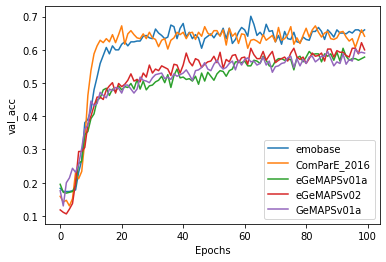

In [23]:
plot_data_testAcc = []
plot_data_testLoss = []
plot_data_trainAcc = []
plot_data_trainLoss = []
for history in history_collection:
    plt.plot(list(range(len(history_collection[history].history['val_acc']))), history_collection[history].history['val_acc'], label = history)
plt.xlabel('Epochs')
plt.ylabel('val_acc')
plt.legend()